# Chapter 3 - Linear Regression

- [Load Datasets](#Load-Datasets)
- [3.1 Simple Linear Regression](#3.1-Simple-Linear-Regression)
- [3.2 Multiple Linear Regression](#3.2-Multiple-Linear-Regression)
- [3.3 Other Considerations in the Regression Model](#3.3-Other-Considerations-in-the-Regression-Model)

In [6]:
# %load ../standard_import.txt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
import seaborn as sns

from sklearn.preprocessing import scale
import sklearn.linear_model as skl_lm
from sklearn.metrics import mean_squared_error, r2_score
import statsmodels.api as sm
import statsmodels.formula.api as smf

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
plt.style.use('seaborn-white')


### Load Datasets
Datasets available on http://www-bcf.usc.edu/~gareth/ISL/data.html

In [7]:
advertising = pd.read_csv('Data/Advertising.csv', usecols=[1,2,3,4])
advertising.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 4 columns):
TV           200 non-null float64
Radio        200 non-null float64
Newspaper    200 non-null float64
Sales        200 non-null float64
dtypes: float64(4)
memory usage: 6.3 KB


In [8]:
advertising.tail()

,TV,Radio,Newspaper,Sales
195,38.2,3.7,13.8,7.6
196,94.2,4.9,8.1,9.7
197,177.0,9.3,6.4,12.8
198,283.6,42.0,66.2,25.5
199,232.1,8.6,8.7,13.4


In [9]:
credit = pd.read_csv('Data/Credit.csv', usecols=list(range(1,12)))
credit['Student2'] = credit.Student.map({'No':0, 'Yes':1})
credit.head(3)

,Income,Limit,Rating,Cards,Age,Education,Gender,Student,Married,Ethnicity,Balance,Student2
0,14.891,3606,283,2,34,11,Male,No,Yes,Caucasian,333,0
1,106.025,6645,483,3,82,15,Female,Yes,Yes,Asian,903,1
2,104.593,7075,514,4,71,11,Male,No,No,Asian,580,0


In [10]:
auto = pd.read_csv('Data/Auto.csv', na_values='?').dropna()
auto.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 392 entries, 0 to 396
Data columns (total 9 columns):
mpg             392 non-null float64
cylinders       392 non-null int64
displacement    392 non-null float64
horsepower      392 non-null float64
weight          392 non-null int64
acceleration    392 non-null float64
year            392 non-null int64
origin          392 non-null int64
name            392 non-null object
dtypes: float64(4), int64(4), object(1)
memory usage: 30.6+ KB


## 3.1 Simple Linear Regression

### Figure 3.1 - Least squares fit

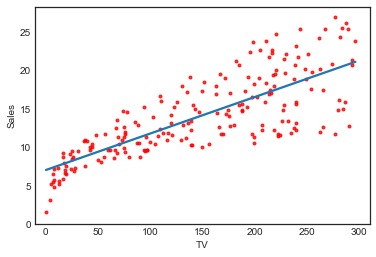

In [11]:
sns.regplot(advertising.TV, advertising.Sales, order=1, ci=None, scatter_kws={'color':'r', 's':9})
plt.xlim(-10,310)
plt.ylim(ymin=0);

### Figure 3.2 - Regression coefficients - RSS
Note that the text in the book describes the coefficients based on uncentered data, whereas the plot shows the model based on centered data. The latter is visually more appealing for explaining the concept of a minimum RSS. I think that, in order not to confuse the reader, the values on the axis of the B0 coefficients have been changed to correspond with the text. The axes on the plots below are unaltered.

In [8]:
# Regression coefficients (Ordinary Least Squares)
regr = skl_lm.LinearRegression()

# Scale (center the data before scaling & scale the data to unit variance if true)
X = scale(advertising.TV, with_mean=True, with_std=False).reshape(-1,1)
y = advertising.Sales

regr.fit(X,y)
print(regr.intercept_)
print(regr.coef_)

14.0225
[0.04753664]


In [9]:
#advertising.TV,X

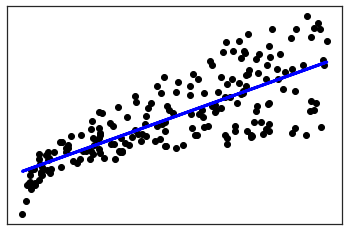

In [10]:
y_pred = regr.predict(X)
# Plot outputs
plt.scatter(X, y,  color='black')
plt.plot(X, y_pred, color='blue', linewidth=3)

plt.xticks(())
plt.yticks(())

plt.show()

### Calculate RSS
Calculate the rss between y & y_pred

In [11]:
np.sum((y - y_pred)**2)

2102.5305831313512

## Figure - Grid plot
Let's see the rss of B0, B1 near the value that we found

In [12]:
# Create grid coordinates for plotting
B0 = np.linspace(regr.intercept_-2, regr.intercept_+2, 50)
B1 = np.linspace(regr.coef_-0.02, regr.coef_+0.02, 50)
xx, yy = np.meshgrid(B0, B1, indexing='xy')
Z = np.zeros((B0.size,B1.size))

# Calculate Z-values (RSS) based on grid of coefficients
for (i,j),v in np.ndenumerate(Z):
    Z[i,j] =((y - (xx[i,j]+X.ravel()*yy[i,j]))**2).sum()

# Minimized RSS
min_RSS = r'$\beta_0$, $\beta_1$ for minimized RSS'
min_rss = np.sum((regr.intercept_+regr.coef_*X - y.values.reshape(-1,1))**2)
min_rss

2102.5305831313512

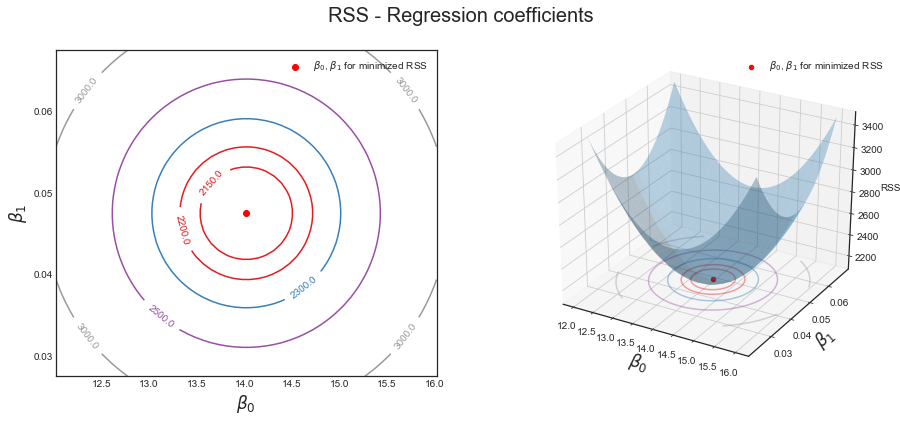

In [13]:
fig = plt.figure(figsize=(15,6))
fig.suptitle('RSS - Regression coefficients', fontsize=20)

ax1 = fig.add_subplot(121)
ax2 = fig.add_subplot(122, projection='3d')

# Left plot
CS = ax1.contour(xx, yy, Z, cmap=plt.cm.Set1, levels=[2150, 2200, 2300, 2500, 3000])
ax1.scatter(regr.intercept_, regr.coef_[0], c='r', label=min_RSS)
ax1.clabel(CS, inline=True, fontsize=10, fmt='%1.1f')

# Right plot
ax2.plot_surface(xx, yy, Z, rstride=3, cstride=3, alpha=0.3)
ax2.contour(xx, yy, Z, zdir='z', offset=Z.min(), cmap=plt.cm.Set1,
            alpha=0.4, levels=[2150, 2200, 2300, 2500, 3000])
ax2.scatter3D(regr.intercept_, regr.coef_[0], min_rss, c='r', label=min_RSS)
ax2.set_zlabel('RSS')
ax2.set_zlim(Z.min(),Z.max())
ax2.set_ylim(0.02,0.07)

# settings common to both plots
for ax in fig.axes:
    ax.set_xlabel(r'$\beta_0$', fontsize=17)
    ax.set_ylabel(r'$\beta_1$', fontsize=17)
    ax.set_yticks([0.03,0.04,0.05,0.06])
    ax.legend()

### Calculate regression coefficients for Radio & Newspaper


In [14]:
regr2 = skl_lm.LinearRegression()
X2 = scale(advertising.Radio, with_mean=True, with_std=False).reshape(-1,1)
regr2.fit(X2,y)
print(regr2.intercept_)
print(regr2.coef_)

regr3 = skl_lm.LinearRegression()
X3 = scale(advertising.Newspaper, with_mean=True, with_std=False).reshape(-1,1)
regr3.fit(X3,y)
print(regr3.intercept_)
print(regr3.coef_)

14.022500000000003
[0.20249578]
14.0225
[0.0546931]


### Plot a graph like Figure 3.2 for Radio & Newspaper
And calculate RSS per each data

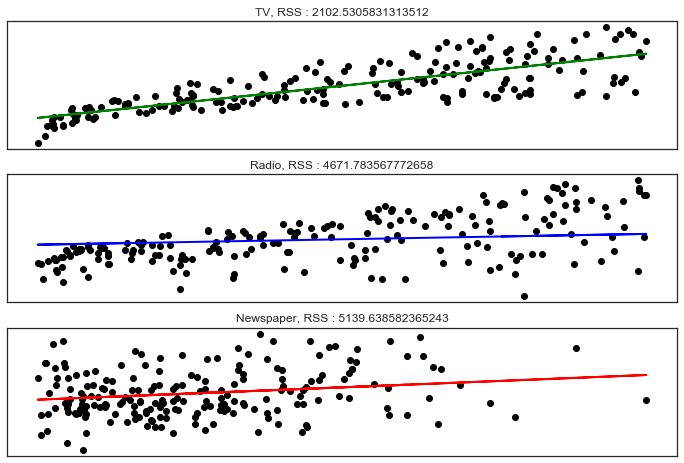

In [15]:
y_pred2 = regr.predict(X2)
y_pred3 = regr.predict(X3)

plt.figure(figsize=(12, 8))
plt.subplot(311)
plt.scatter(X, y,  color='black')
plt.plot(X, y_pred, color='green', linewidth=2)
plt.title("TV, RSS : " + str(np.sum((y - y_pred)**2)))
plt.xticks(())
plt.yticks(())

plt.subplot(312)
plt.scatter(X2, y,  color='black')
plt.plot(X2, y_pred2, color='blue', linewidth=2)
plt.title("Radio, RSS : " + str(np.sum((y - y_pred2)**2)))
plt.xticks(())
plt.yticks(())

plt.subplot(313)
plt.scatter(X3, y,  color='black')
plt.plot(X3, y_pred3, color='red', linewidth=2)
plt.title("Newspaper, RSS : " + str(np.sum((y - y_pred3)**2)))
plt.xticks(())
plt.yticks(())
plt.show()

### T value & Table 3.1 & 3.2 - Statsmodels 

In [16]:
est = smf.ols('Sales ~ TV', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,7.0326,0.458,15.360,0.000,6.130,7.935
TV,0.0475,0.003,17.668,0.000,0.042,0.053


In [17]:
est = smf.ols('Sales ~ Radio', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,9.3116,0.563,16.542,0.000,8.202,10.422
Radio,0.2025,0.020,9.921,0.000,0.162,0.243


In [18]:
est = smf.ols('Sales ~ Newspaper', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,12.3514,0.621,19.876,0.000,11.126,13.577
Newspaper,0.0547,0.017,3.300,0.001,0.022,0.087


## 3.2 Multiple Linear Regression

### Table 3.4 & 3.6 - Statsmodels

In [19]:
est = smf.ols('Sales ~ TV + Radio + Newspaper', advertising).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  Sales   R-squared:                       0.897
Model:                            OLS   Adj. R-squared:                  0.896
Method:                 Least Squares   F-statistic:                     570.3
Date:                Wed, 28 Oct 2020   Prob (F-statistic):           1.58e-96
Time:                        09:18:26   Log-Likelihood:                -386.18
No. Observations:                 200   AIC:                             780.4
Df Residuals:                     196   BIC:                             793.6
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.9389      0.312      9.422      0.000       2.324       3.554
TV             0.0458      0.001     32.809      0.000       0.043       0.049
Radio          0.1885      0.009     21.893      0.000       0.172       0.206
Newspaper     -0.0010      0.006     -0.177      0.860      -0.013       0.011
==============================================================================
Omnibus:                       60.414   Durbin-Watson:                   2.084
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              151.241
Skew:                          -1.327   Prob(JB):                     1.44e-33
Kurtosis:                       6.332   Cond. No.                         454.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Table 3.5 - Correlation Matrix

In [20]:
advertising.corr()

,TV,Radio,Newspaper,Sales
TV,1.000000,0.054809,0.056648,0.782224
Radio,0.054809,1.000000,0.354104,0.576223
Newspaper,0.056648,0.354104,1.000000,0.228299
Sales,0.782224,0.576223,0.228299,1.000000


## Compare t value of TV,Radio and Newpaper with fitness below

Plot the resulting regression line and a 95% confidence interval

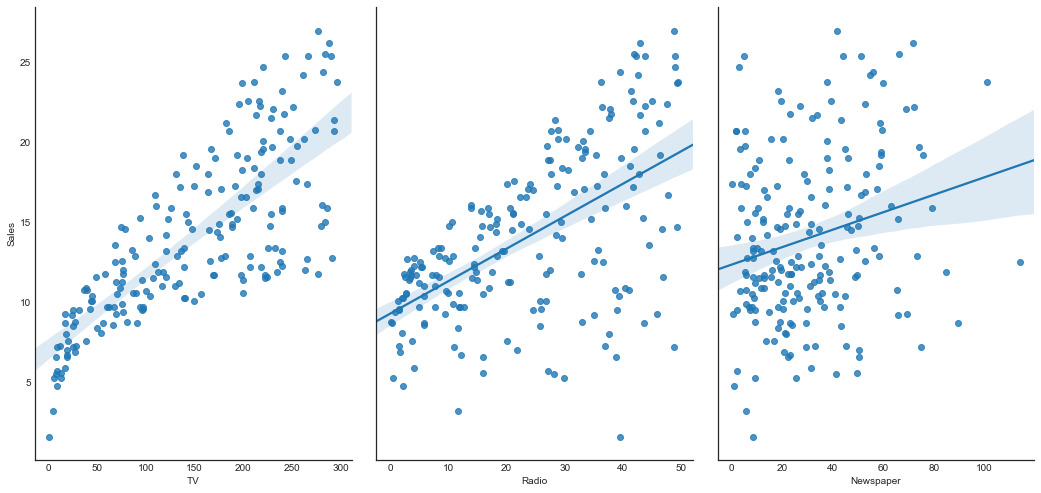

In [21]:
sns.pairplot(advertising, x_vars=['TV', 'Radio', 'Newspaper'], y_vars='Sales', size=7, aspect=0.7, kind='reg')

### Figure 3.5 - Multiple Linear Regression

In [22]:
regr = skl_lm.LinearRegression()

X = advertising[['Radio', 'TV']].as_matrix() #to_numpy as_matrix
y = advertising.Sales

regr.fit(X,y)
print(regr.coef_)
print(regr.intercept_)

[0.18799423 0.04575482]
2.921099912405138


In [23]:
# What are the min/max values of Radio & TV?
# Use these values to set up the grid for plotting.
advertising[['Radio', 'TV']].describe()

,Radio,TV
count,200.000000,200.000000
mean,23.264000,147.042500
std,14.846809,85.854236
min,0.000000,0.700000
25%,9.975000,74.375000
50%,22.900000,149.750000
75%,36.525000,218.825000
max,49.600000,296.400000


In [24]:
# Create a coordinate grid
Radio = np.arange(0,50)
TV = np.arange(0,300)

B1, B2 = np.meshgrid(Radio, TV, indexing='xy')
Z = np.zeros((TV.size, Radio.size))

for (i,j),v in np.ndenumerate(Z):
        Z[i,j] =(regr.intercept_ + B1[i,j]*regr.coef_[0] + B2[i,j]*regr.coef_[1])

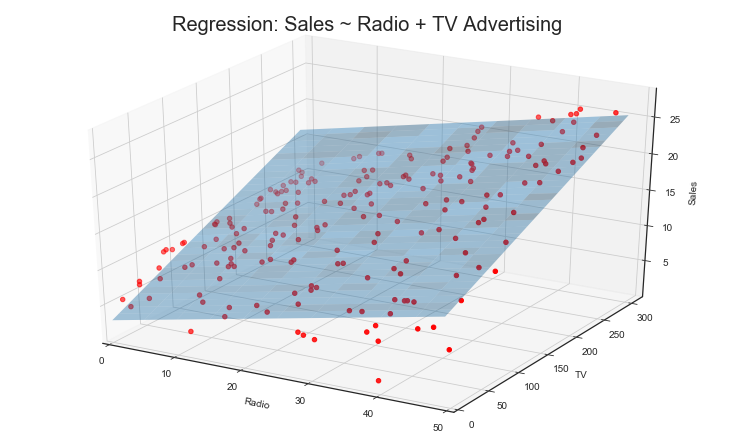

In [25]:
# Create plot
fig = plt.figure(figsize=(10,6))
fig.suptitle('Regression: Sales ~ Radio + TV Advertising', fontsize=20)

ax = axes3d.Axes3D(fig)

ax.plot_surface(B1, B2, Z, rstride=10, cstride=5, alpha=0.4)
ax.scatter3D(advertising.Radio, advertising.TV, advertising.Sales, c='r')

ax.set_xlabel('Radio')
ax.set_xlim(0,50)
ax.set_ylabel('TV')
ax.set_ylim(ymin=0)
ax.set_zlabel('Sales');

In [30]:
regr = skl_lm.LinearRegression()

X = advertising[['Radio', 'TV', 'Newspaper']].as_matrix()
y = advertising.Sales

regr.fit(X,y)
print(regr.coef_)
print(regr.intercept_)

advertising[['Radio', 'TV', 'Newspaper']].describe()

[ 0.18853002  0.04576465 -0.00103749]
2.9388893694594085


,Radio,TV,Newspaper
count,200.000000,200.000000,200.000000
mean,23.264000,147.042500,30.554000
std,14.846809,85.854236,21.778621
min,0.000000,0.700000,0.300000
25%,9.975000,74.375000,12.750000
50%,22.900000,149.750000,25.750000
75%,36.525000,218.825000,45.100000
max,49.600000,296.400000,114.000000


## 3.3 Other Considerations in the Regression Model

### Figure 3.6

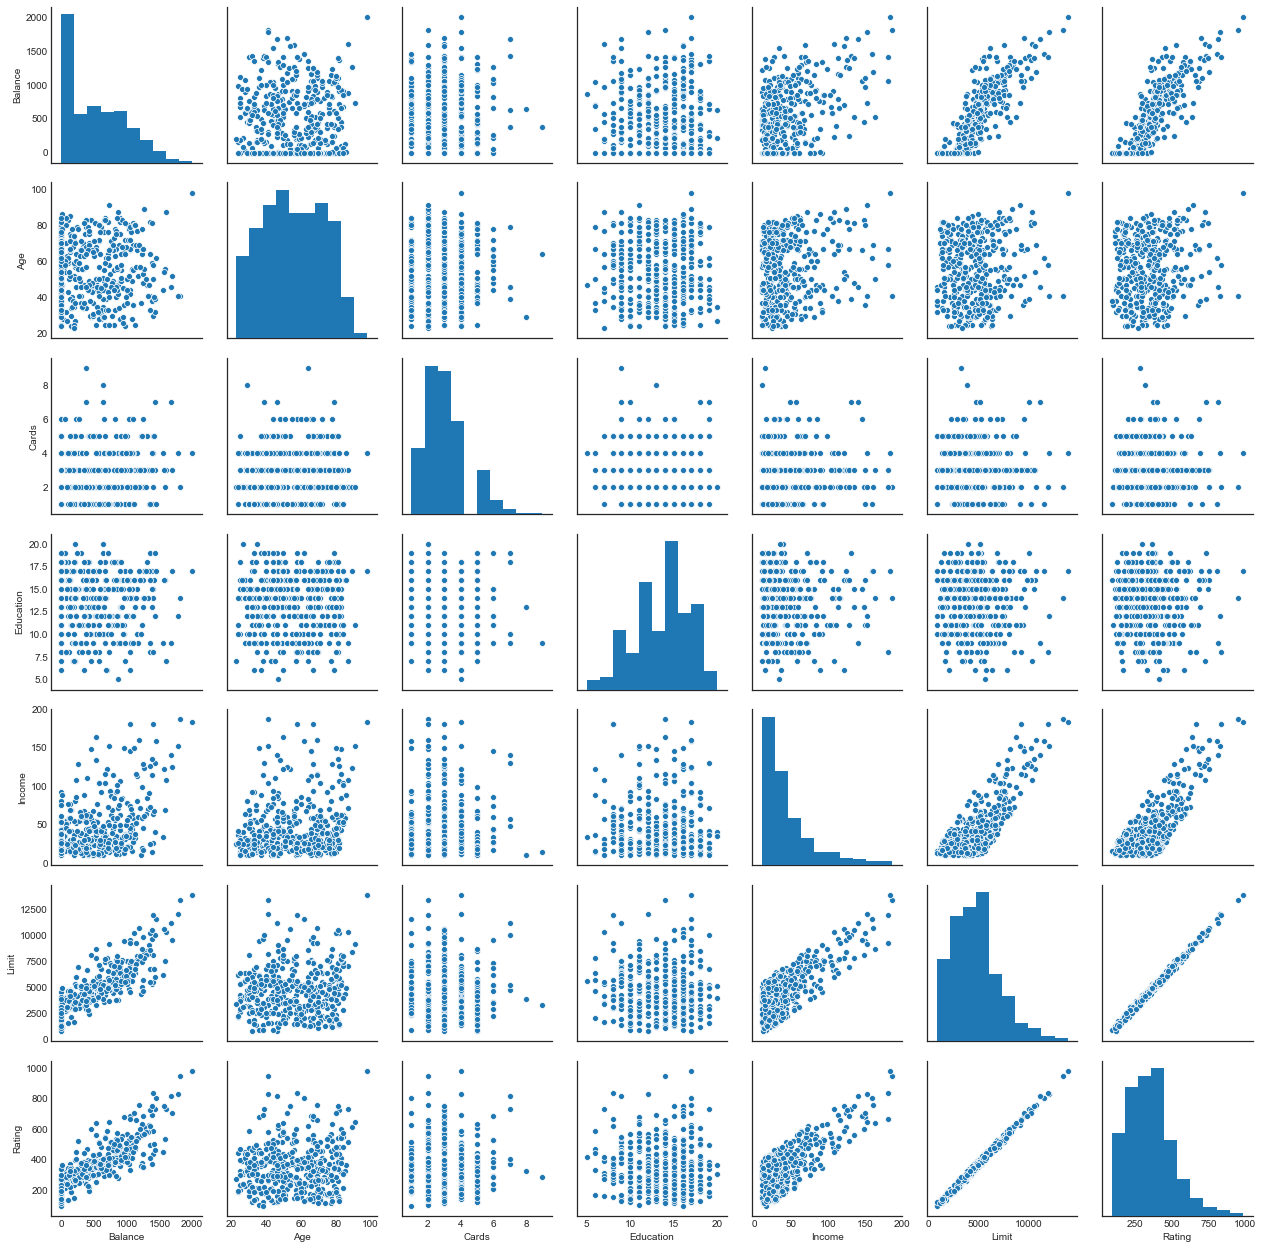

In [31]:
sns.pairplot(credit[['Balance','Age','Cards','Education','Income','Limit','Rating']]);

### Table 3.7
Least squares coefficient estimates associated with the regression of
balance onto gender in the Credit data set. 
Gender is encoded as a dummy variable.

In [32]:
print(credit.Gender.unique())
est = smf.ols('Balance ~ Gender', credit).fit()
est.summary().tables[1]

[' Male' 'Female']


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,nan,nan,nan,nan,nan,nan
Gender[T.Female],nan,nan,nan,nan,nan,nan


### Table 3.8
Least squares coefficient estimates associated with the regression
of balance onto ethnicity in the Credit data set.
Ethnicity is encoded via two dummy variables

In [33]:
print(credit.Ethnicity.unique())
est = smf.ols('Balance ~ Ethnicity', credit).fit()
est.summary().tables[1]

['Caucasian' 'Asian' 'African American']


,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,531.0000,46.319,11.464,0.000,439.939,622.061
Ethnicity[T.Asian],-18.6863,65.021,-0.287,0.774,-146.515,109.142
Ethnicity[T.Caucasian],-12.5025,56.681,-0.221,0.826,-123.935,98.930


### Table 3.9 - Interaction Variables
For the Advertising data, least squares coefficient estimates associated with the regression of sales onto TV and radio, with an interaction term

In [33]:
est = smf.ols('Sales ~ TV + Radio + TV*Radio', advertising).fit()
est.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,6.7502,0.248,27.233,0.000,6.261,7.239
TV,0.0191,0.002,12.699,0.000,0.016,0.022
Radio,0.0289,0.009,3.241,0.001,0.011,0.046
TV:Radio,0.0011,5.24e-05,20.727,0.000,0.001,0.001


### Figure 3.7 - Interaction between qualitative and quantative variables

In [34]:
est1 = smf.ols('Balance ~ Income + Student2', credit).fit()
regr1 = est1.params
est2 = smf.ols('Balance ~ Income + Income*Student2', credit).fit()
regr2 = est2.params

print('Regression 1 - without interaction term')
print(regr1)
print('\nRegression 2 - with interaction term')
print(regr2)

Regression 1 - without interaction term
Intercept    211.142964
Income         5.984336
Student2     382.670539
dtype: float64

Regression 2 - with interaction term
Intercept          200.623153
Income               6.218169
Student2           476.675843
Income:Student2     -1.999151
dtype: float64


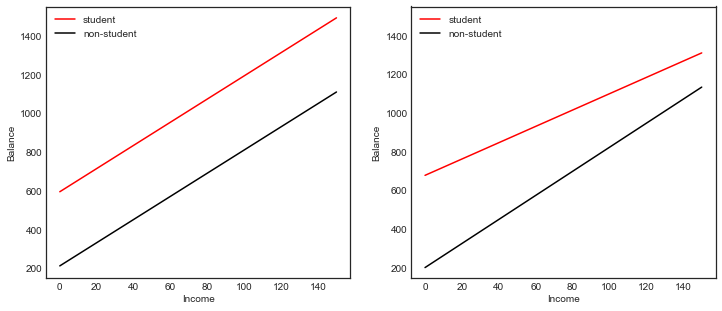

In [35]:
# Income (x-axis)
income = np.linspace(0,150)

# Balance without interaction term (y-axis)
student1 = np.linspace(regr1['Intercept']+regr1['Student2'],
                       regr1['Intercept']+regr1['Student2']+150*regr1['Income'])
non_student1 =  np.linspace(regr1['Intercept'], regr1['Intercept']+150*regr1['Income'])

# Balance with iteraction term (y-axis)
student2 = np.linspace(regr2['Intercept']+regr2['Student2'],
                       regr2['Intercept']+regr2['Student2']+
                       150*(regr2['Income']+regr2['Income:Student2']))
non_student2 =  np.linspace(regr2['Intercept'], regr2['Intercept']+150*regr2['Income'])

# Create plot
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))
ax1.plot(income, student1, 'r', income, non_student1, 'k')
ax2.plot(income, student2, 'r', income, non_student2, 'k')

for ax in fig.axes:
    ax.legend(['student', 'non-student'], loc=2)
    ax.set_xlabel('Income')
    ax.set_ylabel('Balance')
    ax.set_ylim(ymax=1550)

### Figure 3.8 - Non-linear relationships

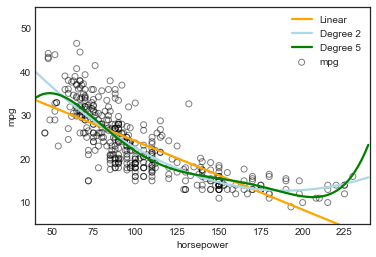

In [36]:
# With Seaborn's regplot() you can easily plot higher order polynomials.
plt.scatter(auto.horsepower, auto.mpg, facecolors='None', edgecolors='k', alpha=.5) 
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Linear', scatter=False, color='orange')
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Degree 2', order=2, scatter=False, color='lightblue')
sns.regplot(auto.horsepower, auto.mpg, ci=None, label='Degree 5', order=5, scatter=False, color='g')
plt.legend()
plt.ylim(5,55)
plt.xlim(40,240);

### Figure 3.9

In [37]:
auto['horsepower2'] = auto.horsepower**2
auto['h:c'] = auto.horsepower*auto.cylinders

regr = skl_lm.LinearRegression()

# Linear fit
X = auto.horsepower.values.reshape(-1,1)
y = auto.mpg
regr.fit(X, y)

auto['pred1'] = regr.predict(X)
auto['resid1'] = auto.mpg - auto.pred1

# Quadratic fit
X2 = auto[['horsepower', 'horsepower2']].as_matrix()
regr.fit(X2, y)

auto['pred2'] = regr.predict(X2)
auto['resid2'] = auto.mpg - auto.pred2

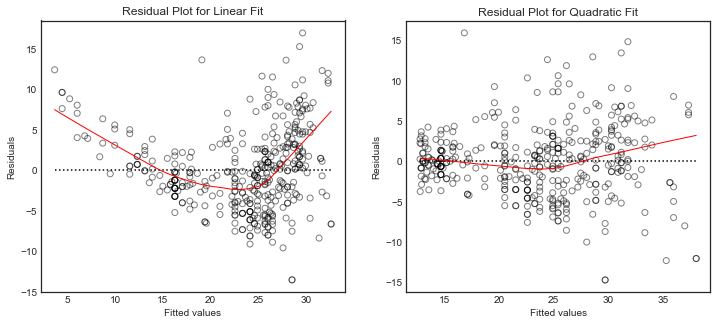

In [38]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(12,5))

# Left plot
sns.regplot(auto.pred1, auto.resid1, lowess=True, 
            ax=ax1, line_kws={'color':'r', 'lw':1},
            scatter_kws={'facecolors':'None', 'edgecolors':'k', 'alpha':0.5})
ax1.hlines(0,xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dotted')
ax1.set_title('Residual Plot for Linear Fit')

# Right plot
sns.regplot(auto.pred2, auto.resid2, lowess=True,
            line_kws={'color':'r', 'lw':1}, ax=ax2,
            scatter_kws={'facecolors':'None', 'edgecolors':'k', 'alpha':0.5})
ax2.hlines(0,xmin=ax2.xaxis.get_data_interval()[0],
           xmax=ax2.xaxis.get_data_interval()[1], linestyles='dotted')
ax2.set_title('Residual Plot for Quadratic Fit')

for ax in fig.axes:
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')

### Exercise - Try to use high order polynomial & interaction term in sklearn

PolynomialFeatures & OneHotEncoder

In [39]:
auto.head(15)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name,horsepower2,h:c,pred1,resid1,pred2,resid2
0,18.0,8,307.0,130.0,3504,12.0,70,1,chevrolet chevelle malibu,16900.0,1040.0,19.416046,-1.416046,17.091508,0.908492
1,15.0,8,350.0,165.0,3693,11.5,70,1,buick skylark 320,27225.0,1320.0,13.891480,1.108520,13.480156,1.519844
2,18.0,8,318.0,150.0,3436,11.0,70,1,plymouth satellite,22500.0,1200.0,16.259151,1.740849,14.658717,3.341283
3,16.0,8,304.0,150.0,3433,12.0,70,1,amc rebel sst,22500.0,1200.0,16.259151,-0.259151,14.658717,1.341283
4,17.0,8,302.0,140.0,3449,10.5,70,1,ford torino,19600.0,1120.0,17.837598,-0.837598,15.752059,1.247941
5,15.0,8,429.0,198.0,4341,10.0,70,1,ford galaxie 500,39204.0,1584.0,8.682604,6.317396,12.836490,2.163510
6,14.0,8,454.0,220.0,4354,9.0,70,1,chevrolet impala,48400.0,1760.0,5.210020,8.789980,13.896328,0.103672
7,14.0,8,440.0,215.0,4312,8.5,70,1,plymouth fury iii,46225.0,1720.0,5.999243,8.000757,13.550861,0.449139
8,14.0,8,455.0,225.0,4425,10.0,70,1,pontiac catalina,50625.0,1800.0,4.420796,9.579204,14.303323,-0.303323
9,15.0,8,390.0,190.0,3850,8.5,70,1,amc ambassador dpl,36100.0,1520.0,9.945362,5.054638,12.746423,2.253577


In [40]:
X = auto[['horsepower', 'weight']]
print(X[:3])

horsepower  weight
0       130.0    3504
1       165.0    3693
2       150.0    3436


In [41]:
from sklearn.preprocessing import PolynomialFeatures, OneHotEncoder

poly = PolynomialFeatures(2)
# 1, horsepower, weight, horsepower^2, horsepower*weight, weight^2
print(poly.fit_transform(X)[:3])

[[1.0000000e+00 1.3000000e+02 3.5040000e+03 1.6900000e+04 4.5552000e+05
  1.2278016e+07]
 [1.0000000e+00 1.6500000e+02 3.6930000e+03 2.7225000e+04 6.0934500e+05
  1.3638249e+07]
 [1.0000000e+00 1.5000000e+02 3.4360000e+03 2.2500000e+04 5.1540000e+05
  1.1806096e+07]]


In [42]:
poly_interaction = PolynomialFeatures(interaction_only=True)
poly_interaction.fit_transform(X)
# 1, horsepower, weight, horsepower*weight
print(poly_interaction.fit_transform(X)[:3])

[[1.00000e+00 1.30000e+02 3.50400e+03 4.55520e+05]
 [1.00000e+00 1.65000e+02 3.69300e+03 6.09345e+05]
 [1.00000e+00 1.50000e+02 3.43600e+03 5.15400e+05]]


In [43]:
X2 = auto[['origin']]
enc = OneHotEncoder()
enc.fit(X2)
print(enc.transform(X2).toarray()[:,:-1][10:15])

[[1. 0.]
 [1. 0.]
 [1. 0.]
 [1. 0.]
 [0. 0.]]


In [44]:
print(poly.fit_transform(X).shape)
print(enc.transform(X2).toarray().shape)
print(np.concatenate([poly.fit_transform(X),enc.transform(X2).toarray()[:,:-1]], 1).shape)

(392, 6)
(392, 3)
(392, 8)


In [45]:
regr = skl_lm.LinearRegression()

x_poly = np.concatenate([poly.fit_transform(X),enc.transform(X2).toarray()[:,:-1]], 1)
y = auto.mpg

regr.fit(x_poly, y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

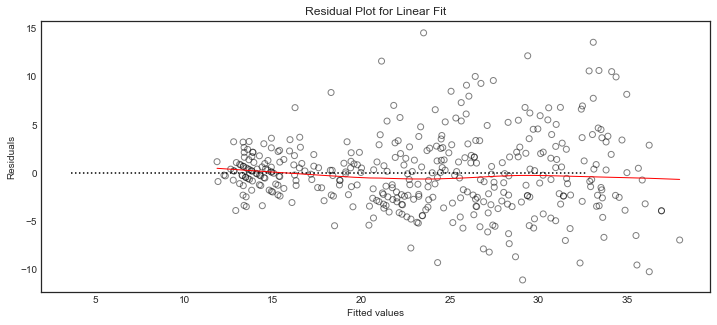

In [46]:
fig, (ax3) = plt.subplots(1,1, figsize=(12,5))

# Left plot
sns.regplot(regr.predict(x_poly), y - regr.predict(x_poly), lowess=True, 
            ax=ax3, line_kws={'color':'r', 'lw':1},
            scatter_kws={'facecolors':'None', 'edgecolors':'k', 'alpha':0.5})
ax3.hlines(0,xmin=ax1.xaxis.get_data_interval()[0],
           xmax=ax1.xaxis.get_data_interval()[1], linestyles='dotted')
ax3.set_title('Residual Plot for Linear Fit')

for ax in fig.axes:
    ax.set_xlabel('Fitted values')
    ax.set_ylabel('Residuals')
